In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, measure
from matplotlib.patches import Rectangle

In [2]:
def obter_centro_elemento_estruturante(elemento_estruturante):
    """
    Determina a posição central (linha, coluna) de um elemento estruturante.

    Parâmetros:
    elemento_estruturante (numpy.ndarray):
        Representação do elemento estruturante em um array NumPy.

    Retorna:
    tuple:
        Coordenada (linha, coluna) que indica o ponto central do elemento.
    """
    linhas, colunas = elemento_estruturante.shape
    return (linhas // 2, colunas // 2)

In [3]:
def erodir_imagem(img, ee, repeticoes=1):
    """
    Aplica a operação de erosão em uma imagem usando um elemento estruturante.

    Parâmetros:
    img (numpy.ndarray):
        Imagem de entrada.
    ee (numpy.ndarray):
        Elemento estruturante para a erosão.
    repeticoes (int, opcional):
        Número de repetições da operação de erosão.

    Retorna:
    numpy.ndarray:
        Imagem erodida resultante.
    """
    centro_ee = obter_centro_elemento_estruturante(ee)
    linhas_ee, colunas_ee = ee.shape

    tam_sup, tam_esq = centro_ee
    tam_inf = linhas_ee - centro_ee[0] - 1
    tam_dir = colunas_ee - centro_ee[1] - 1

    resultado_erosao = img.copy()
    for _ in range(repeticoes):
        img_expandida = np.pad(
            resultado_erosao,
            ((tam_sup, tam_inf), (tam_esq, tam_dir)),
            mode="constant",
            constant_values=resultado_erosao.max(),
        )
        janelas_2d = np.lib.stride_tricks.sliding_window_view(
            img_expandida, (linhas_ee, colunas_ee)
        )
        valor_mascarado = np.where(ee, janelas_2d, np.inf)
        resultado_erosao = valor_mascarado.min(axis=(-2, -1))

    return resultado_erosao

In [4]:
def dilatar_imagem(imagem, elemento_estruturante, iteracoes=1):
    """
    Aplica a operação de dilatação em uma imagem usando um elemento estruturante.

    Parâmetros:
    imagem (numpy.ndarray):
        Imagem de entrada.
    elemento_estruturante (numpy.ndarray):
        Elemento estruturante utilizado na dilatação.
    iteracoes (int, opcional):
        Número de vezes que a operação será executada.

    Retorna:
    numpy.ndarray:
        Imagem resultante após a aplicação da dilatação.
    """
    centro_elemento = obter_centro_elemento_estruturante(elemento_estruturante)
    altura_elemento, largura_elemento = elemento_estruturante.shape

    delta_superior, delta_esquerdo = centro_elemento
    delta_inferior = altura_elemento - centro_elemento[0] - 1
    delta_direito = largura_elemento - centro_elemento[1] - 1

    resultado = imagem.copy()
    for _ in range(iteracoes):
        imagem_preenchida = np.pad(
            resultado,
            ((delta_superior, delta_inferior), (delta_esquerdo, delta_direito)),
            mode="constant",
            constant_values=resultado.min(),
        )
        janelas = np.lib.stride_tricks.sliding_window_view(
            imagem_preenchida, (altura_elemento, largura_elemento)
        )
        mascarado = np.where(elemento_estruturante, janelas, -np.inf)
        resultado = mascarado.max(axis=(-2, -1))

    return resultado

In [5]:
def abertura_imagem(imagem, elemento_estruturante, iteracoes=1):
    """
    Realiza a operação de abertura em uma imagem, que consiste em uma erosão 
    seguida de uma dilatação usando o mesmo elemento estruturante.

    Parâmetros:
    imagem (numpy.ndarray):
        Imagem de entrada.
    elemento_estruturante (numpy.ndarray):
        Elemento estruturante aplicado na abertura.
    iteracoes (int, opcional):
        Número de vezes que a operação de cada etapa (erosão e dilatação) será aplicada.

    Retorna:
    numpy.ndarray:
        Imagem resultante após a operação de abertura.
    """
    imagem_erodida = erodir_imagem(imagem, elemento_estruturante, iteracoes)
    return dilatar_imagem(imagem_erodida, elemento_estruturante, iteracoes)

In [6]:
def fechamento_imagem(imagem, elemento_estruturante, iteracoes=1):
    """
    Realiza a operação de fechamento em uma imagem, que consiste em uma dilatação
    seguida de uma erosão com o mesmo elemento estruturante.

    Parâmetros:
    imagem (numpy.ndarray):
        Imagem de entrada.
    elemento_estruturante (numpy.ndarray):
        Elemento estruturante usado no fechamento.
    iteracoes (int, opcional):
        Número de vezes que a operação de cada etapa (dilatação e erosão) será aplicada.

    Retorna:
    numpy.ndarray:
        Imagem resultante após a operação de fechamento.
    """
    imagem_dilatada = dilatar_imagem(imagem, elemento_estruturante, iteracoes)
    return erodir_imagem(imagem_dilatada, elemento_estruturante, iteracoes)

In [7]:
def elemento_estruturante_disco(dimensoes):
    """
    Cria um elemento estruturante em formato de disco.

    Parâmetros:
    dimensoes (tuple):
        Dimensões (linhas, colunas) desejadas para o disco.

    Retorna:
    numpy.ndarray:
        Matriz binária (0 e 1) representando o disco.
    """
    disco = np.zeros(dimensoes, dtype=np.uint8)
    raio = min(dimensoes[0], dimensoes[1]) // 2

    for i in range(dimensoes[0]):
        for j in range(dimensoes[1]):
            distancia = ((i - dimensoes[0] // 2) ** 2) + ((j - dimensoes[1] // 2) ** 2)
            if distancia <= raio * raio:
                disco[i, j] = 1

    return disco

In [8]:
def carregar_exibir_e_equalizar_imagem(caminho_imagem):
    """
    Carrega uma imagem do disco, converte-a para escala de cinza,
    exibe a imagem, mostra o histograma normalizado e realiza a
    equalização de histograma de forma manual.

    Parâmetros:
    caminho_imagem (str):
        Caminho do arquivo de imagem no disco.

    Retorna:
    numpy.ndarray:
        Imagem equalizada em escala de cinza.
    """
    # Carrega a imagem
    imagem_original = io.imread(caminho_imagem)

    # Converte para escala de cinza, se necessário
    if len(imagem_original.shape) == 3:
        imagem_cinza = color.rgb2gray(imagem_original)
    else:
        imagem_cinza = imagem_original

    # Exibe a imagem em escala de cinza
    plt.imshow(imagem_cinza, cmap="gray")
    plt.title("Imagem em Escala de Cinza")
    plt.axis("off")
    plt.show()

    # Calcula e exibe o histograma normalizado
    histograma, _ = np.histogram(imagem_cinza, bins=256)
    histograma = histograma.astype(float) / (
        imagem_cinza.shape[0] * imagem_cinza.shape[1]
    )
    plt.plot(histograma, "-k")
    plt.title("Histograma Normalizado")
    plt.show()

    # Equaliza manualmente o histograma
    hist, _ = np.histogram(imagem_cinza, bins=256, range=(0, 1))
    hist = hist.astype(float) / (imagem_cinza.shape[0] * imagem_cinza.shape[1])
    transformada = (np.cumsum(hist) * 256).astype("uint8")

    imagem_equalizada = np.zeros(imagem_cinza.shape, dtype=np.uint8)
    linhas, colunas = imagem_cinza.shape
    for i in range(linhas):
        for j in range(colunas):
            indice = int(imagem_cinza[i, j] * 255)
            imagem_equalizada[i, j] = transformada[indice]

    # Exibe a imagem equalizada
    plt.imshow(imagem_equalizada, cmap="gray")
    plt.title("Imagem Equalizada Manualmente")
    plt.axis("off")
    plt.show()

    return imagem_equalizada

In [9]:
def processar_imagem_pos_equalizacao(imagem_equalizada):
    """
    Executa uma cadeia de operações morfológicas em uma imagem já equalizada:
      1. Cria um elemento estruturante em formato de disco (3x3).
      2. Aplica a abertura por 20 iterações para eliminar ruídos.
      3. Subtrai a imagem equalizada da imagem resultante da abertura.
      4. Realiza a binarização (threshold) sobre a imagem subtraída.
      5. Executa uma abertura na imagem binarizada, para limpar ruídos remanescentes.
      6. Finaliza com um fechamento, garantindo contiguidade das estruturas.

    Parâmetros:
    imagem_equalizada (numpy.ndarray):
        Imagem em escala de cinza que já foi equalizada manualmente.

    Retorna:
    numpy.ndarray:
        Imagem resultante após todas as operações morfológicas.
    """
    # Passo 1: Cria o elemento estruturante em disco (3x3)
    elemento_estruturante_formato_disco_3x3 = elemento_estruturante_disco((3, 3))

    # Passo 2: Aplicação da abertura (20 iterações) para remover ruídos finos
    imagem_abertura_inicial = abertura_imagem(
        imagem_equalizada, elemento_estruturante_formato_disco_3x3, iteracoes=20
    )
    plt.imshow(imagem_abertura_inicial, cmap="gray")
    plt.title("Imagem após Abertura (20 Iterações)")
    plt.axis("off")
    plt.show()

    # Passo 3: Subtrai a imagem de abertura da imagem equalizada e ajusta intervalo
    imagem_subtraida_abertura = imagem_equalizada.astype(
        np.int16
    ) - imagem_abertura_inicial.astype(np.int16)
    imagem_subtraida_abertura = np.clip(imagem_subtraida_abertura, 0, 255).astype(
        np.uint8
    )
    plt.imshow(imagem_subtraida_abertura, cmap="gray")
    plt.title("Diferença: Equalizada - Abertura (Ajustada)")
    plt.axis("off")
    plt.show()

    # Passo 4: Binariza a imagem resultante (threshold = 120)
    limiar_binario = 120
    imagem_binarizada = imagem_subtraida_abertura.copy()
    imagem_binarizada[imagem_binarizada < limiar_binario] = 0
    imagem_binarizada[imagem_binarizada >= limiar_binario] = 255
    plt.imshow(imagem_binarizada, cmap="gray")
    plt.title("Imagem Binarizada")
    plt.axis("off")
    plt.show()

    # Passo 5: Aplica a abertura na imagem binarizada para remover pontos isolados
    imagem_abertura_binaria = abertura_imagem(
        imagem_binarizada, elemento_estruturante_formato_disco_3x3, iteracoes=1
    )
    plt.imshow(imagem_abertura_binaria, cmap="gray")
    plt.title("Abertura Pós-Binarização (1 Iteração)")
    plt.axis("off")
    plt.show()

    # Passo 6: Aplica o fechamento para reforçar a continuidade das estruturas
    imagem_fechada_final = fechamento_imagem(
        imagem_abertura_binaria, elemento_estruturante_formato_disco_3x3, iteracoes=4
    )
    plt.imshow(imagem_fechada_final, cmap="gray")
    plt.title("Fechamento Final (4 Iterações)")
    plt.axis("off")
    plt.show()

    return imagem_fechada_final

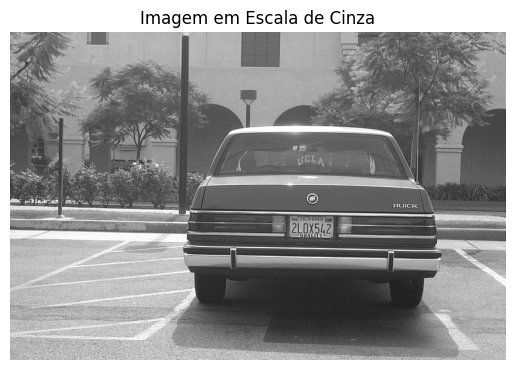

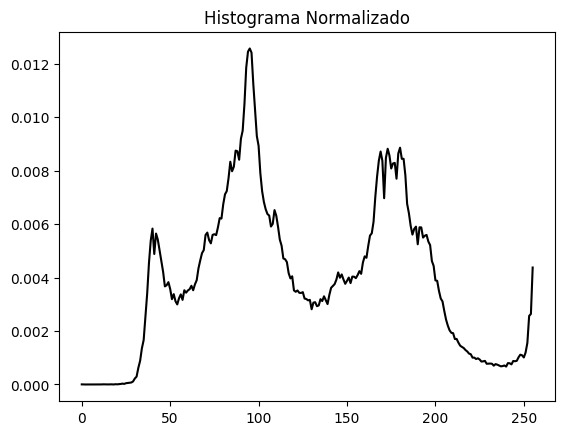

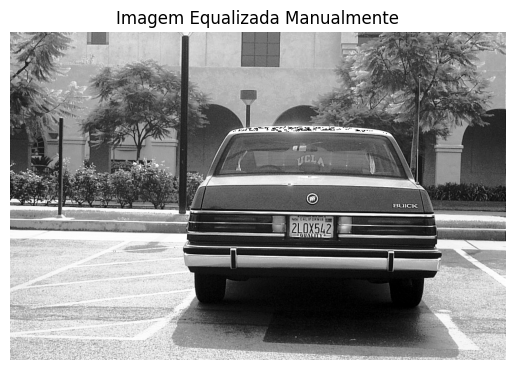

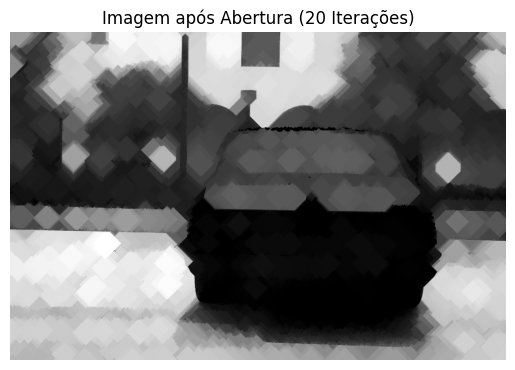

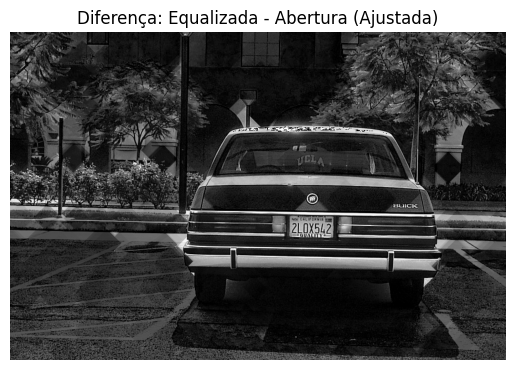

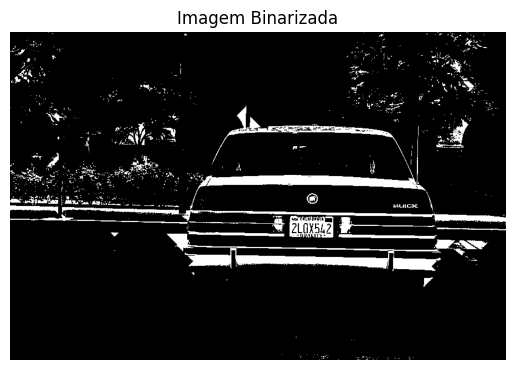

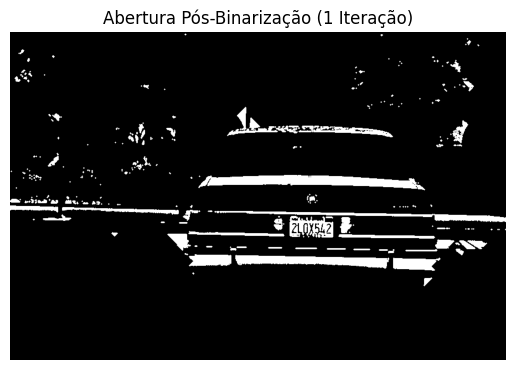

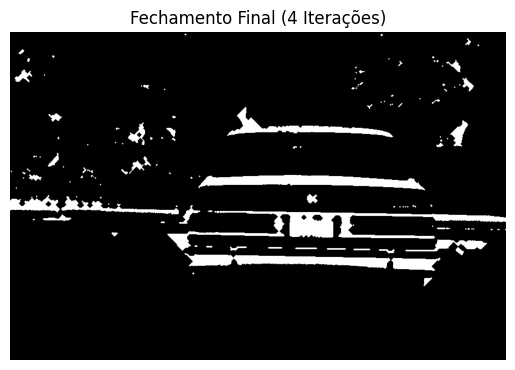

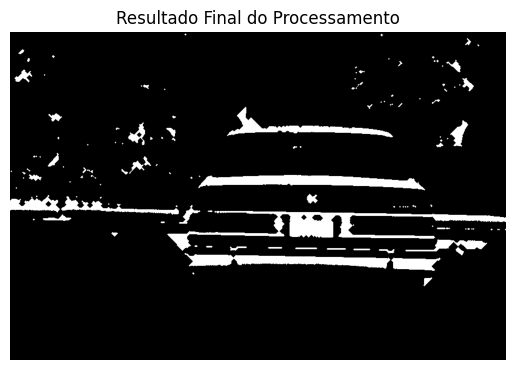

In [10]:
# Caminho para a imagem que você deseja processar
caminho_imagem = "imagens/image_0001.jpg"

# Carrega e equaliza a imagem
imagem_equalizada = carregar_exibir_e_equalizar_imagem(caminho_imagem)

# Processa a imagem equalizada com a função criada
resultado_final = processar_imagem_pos_equalizacao(imagem_equalizada)

# Exibe o resultado final
plt.imshow(resultado_final, cmap="gray")
plt.title("Resultado Final do Processamento")
plt.axis("off")
plt.show()